In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import numpy as np

In [142]:
# Load the dataset with recon_error
df = pd.read_csv("../data/processed/dev_with_recon.csv")

# Separate features and label
X = df.drop(columns=["Class"])
X["recon_error"] = np.log1p(X["recon_error"])
y = df["Class"]

# Train/test split (stratify to keep same fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (4119, 31)  Test: (1373, 31)


In [143]:
# Baseline: drop recon_error
X_train_base = X_train.drop(columns=["recon_error"])
X_test_base  = X_test.drop(columns=["recon_error"])

# Hybrid: keep recon_error
X_train_hybrid = X_train.copy()
X_test_hybrid  = X_test.copy()


In [144]:
def evaluate_model(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    metrics = {
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_pred_proba),
        "PR_AUC": average_precision_score(y_true, y_pred_proba)
    }
    for k,v in metrics.items():
        print(f"{k:10s}: {v:0.4f}")
    return metrics


In [145]:
base_model = LGBMClassifier(
    n_estimators=450,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    reg_lambda=0.5,
    reg_alpha=0.3
)

base_model.fit(X_train_base, y_train)
base_pred_proba = base_model.predict_proba(X_test_base)[:,1]

print("=== Baseline (no AE feature) ===")
base_metrics = evaluate_model(y_test, base_pred_proba)


[LightGBM] [Info] Number of positive: 369, number of negative: 3750
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 4119, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [147]:
from xgboost import XGBClassifier

hyb_xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train)/sum(y_train)),  # handles imbalance
    eval_metric="aucpr",
    random_state=42,
)

hyb_xgb.fit(X_train_hybrid, y_train)
xgb_pred_proba = hyb_xgb.predict_proba(X_test_hybrid)[:,1]
print("=== Hybrid XGBoost ===")
hybrid_metrics = evaluate_model(y_test, xgb_pred_proba)


=== Hybrid XGBoost ===
Precision : 0.9545
Recall    : 0.8537
F1        : 0.9013
ROC_AUC   : 0.9852
PR_AUC    : 0.9296


In [148]:
pd.DataFrame([base_metrics, hybrid_metrics], index=["Baseline","Hybrid"])

,Precision,Recall,F1,ROC_AUC,PR_AUC
Baseline,0.945946,0.853659,0.897436,0.984085,0.909917
Hybrid,0.954545,0.853659,0.901288,0.985223,0.929647


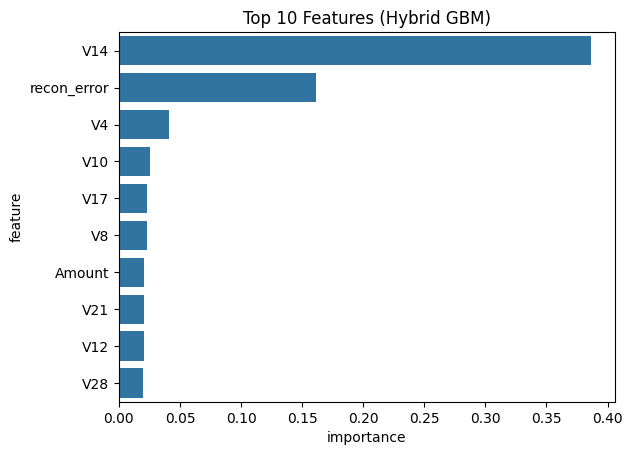

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

imp = pd.DataFrame({
    "feature": X_train_hybrid.columns,
    "importance": hyb_xgb.feature_importances_
}).sort_values("importance", ascending=False)

sns.barplot(data=imp.head(10), x="importance", y="feature")
plt.title("Top 10 Features (Hybrid GBM)")
plt.show()


In [150]:
from sklearn.metrics import confusion_matrix

def print_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"{title}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    return fp, fn

y_base = (base_pred_proba>=0.5).astype(int)
y_hyb  = (xgb_pred_proba>=0.5).astype(int)

fp_base, fn_base = print_confusion(y_test, y_base, "Baseline")
fp_hyb,  fn_hyb  = print_confusion(y_test, y_hyb, "Hybrid")

false_pos_reduction = (fp_base - fp_hyb) / fp_base * 100
print(f"\nFalse Positives reduced by {false_pos_reduction:.2f}%")


Baseline
TP=105, FP=6, FN=18, TN=1244
Hybrid
TP=105, FP=5, FN=18, TN=1245

False Positives reduced by 16.67%
